# Vorhersage von Nachfüllzeitpunkten eines Holzofens

## Entwicklung eines Machine Learning Modells

**Glenn Ehrens**
12750
glenn.ehrens@nordakademie.de

**Marie Frerichs**
12779
marie.frerichs@nordakademie.de

**Noah Peeters**
12756
noah.peeters@nordakademie.de

**Moritz Schröder**
12660
moritz.schroeder@nordakademie.de

Modul: Maschinelles Lernen
Prüfer: Uwe Neuhaus
Abgabe: 10.09.2023

# Funktionsweise und Energiefluss

<img src="pictures/HDG F Schnittbild.png" width="400" alt="Schnittbild HDG F" />

Der Kessel des HDG F verfügt über eine große Füllöffnung, durch die der Füllschacht mit Holz befüllt wird. Im ersten Schritt wird das Holz vergast und anschließend bei hohen Temperaturen verbrannt. Währenddessen werden Primär- und Sekundärluftmengen durch Stellmotoren geregelt und Gase nachverbrannt bzw. abgesaugt. Die durch den Prozess entstandene Wärmeenergie wird mithilfe eines Wärmetauschers in einem Wasserpuffer gespeichert. Dieses Wasser wird direkt zum Heizen in die Heizkörper gepumpt. Um Warmwasser zu erzeugen, wird frisches Wasser über einen zweiten Wärmetauscher aufgeheizt. In der Aschelade sammeln sich die Verbrennungsrückstände, welche entsorgt werden müssen. Der Ofen wird durch ein Touch-Display bedient.

[Holzvergaser – maximale Wirkungsgrade mit zwei Brennkammern](https://www.thermondo.de/info/rat/erneuerbare-energie/holzvergaser/)

Im Diagramm ist der Energiefluss noch einmal schematisch abgebildet. Je nach Jahreszeit variieren die Anteile für Heizung und Warmwasser.

[Sankey Diagram in Python](https://plotly.com/python/sankey-diagram/)


In [7]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Holz", "Luft", "Verlust", "Puffer", "Heizkörper", "Warmwasser"],
      color = ["rgb(124, 71, 0)", "rgb(0,255,255)", "rgb(128,128,128)", "rgb(0,128,0)", "rgb(255,0,0)", "rgb(0,0,255)"],
      x = [0, 0.3, 0.8, 0.6, 0.9, 0.9],
      y = [0.5, 0.5, 1.1, 0.48, 0.2, 0.8]  
    ),
    link = dict(
      source = [0, 1, 1, 3, 3, 3],
      target = [1, 2, 3, 4, 5, 2],
      value = [100, 5, 95, 65, 15, 15],
      color = ["rgba(124, 71, 0,0.2)", "rgba(128,128,128,0.2)", "rgba(0,255,255,0.2)", "rgba(255,0,0,0.2)", "rgba(0,0,255,0.2)", "rgba(128,128,128,0.2)"]
  ))])

fig.update_layout(title_text="Energieflussdiagramm Holzvergaser", font_size=15, plot_bgcolor='rgba(0, 0, 0, 0)', paper_bgcolor='rgba(0, 0, 0, 0)',)
fig.show()

# Zustände

Das Aufheizen des Wassers im Puffer findet nicht kontinuierlich, sondern chargenweise statt. Deshalb kann sich der Holzvergaser in verschiedenen Zuständen befinden. Da diese im weiteren Verlauf der Arbeit relevant sind, werden sie hier kurz aufgeführt. Zu Beginn ist der Holzvergaser ausgeschaltet. Beim Befüllen des Ofens gibt es zwei Möglichkeiten: Er kann entweder direkt oder automatisch angezündet werden (Zündung bereit). 
Bei beiden Methoden startet die Nachlegetaste den Anheizvorgang. Zunächst müssen dann die Holzart, die Holzfeuchte, und die Zündart angegeben werden. Holzart und Holzfeuchte wirken sich auf die Brenndauer aus, daher sind diese zur Berechnung des nächsten Nachlegezeitpunktes entscheidend. Im nächsten Schritt wird der Nachlegebedarf angezeigt. Nun muss angegeben werden, wieviel Holz tatsächlich nachgelegt werden soll. Anhand dieser Angabe wird dann voraussichtlich nächste Nachlegezeitpunkt angezeigt. Nach diesen Angaben kann der Füllschacht geöffnet und befüllt werden.
Die manuelle Zündung erfolgt, indem kleines Holz bzw. Papier oder Pappe direkt angezündet wird. Auf dieses wird dann das Holz gestapelt und der Ofen geschlossen.
Bei der automatischen Funktionsweise muss kleines Holz bzw. Papier oder Pappe vor das Zündloch gelegt und Holz darauf gestapelt werden. Die Tür wird geschlossen und die Zündung bestätigt. Diese kann entweder sofort oder nach Aufforderung ausgeführt werden. Ist der Holzvergaser bereits in Benutzung, wartet er, bis ein Pufferladegrad von 15 % unterschritten wird und zündet dann das nachgefüllte Holz mit einem Heißluftgebläse an. Ist die Zündung erfolgt, wechselt der Zustand in den Automatikmodus, bei dem das Holz vollständig verbrannt wird. Wenn nur noch Glut übrig ist, wechselt der Ofen in den Zustand Ausbrennen. Hier gibt es zwei Möglichkeiten. Entweder wird eine neue Charge Holz nachgelegt und der Ofen brennt wieder im Automatikmodus, oder er wechselt nach komplettem Ausbrennen in den ausgeschalteten Zustand.

Um einen Überblick über die verschiedenen Zustände des Ofens zu bekommen, sind die Wichtigsten weiter unten in einem Flussdiagramm abgebildet. Diese werden auch im entwickelten Modell eine entscheidende Rolle spielen.
[Flowcharting](https://schemdraw.readthedocs.io/en/latest/gallery/flowcharting.html)

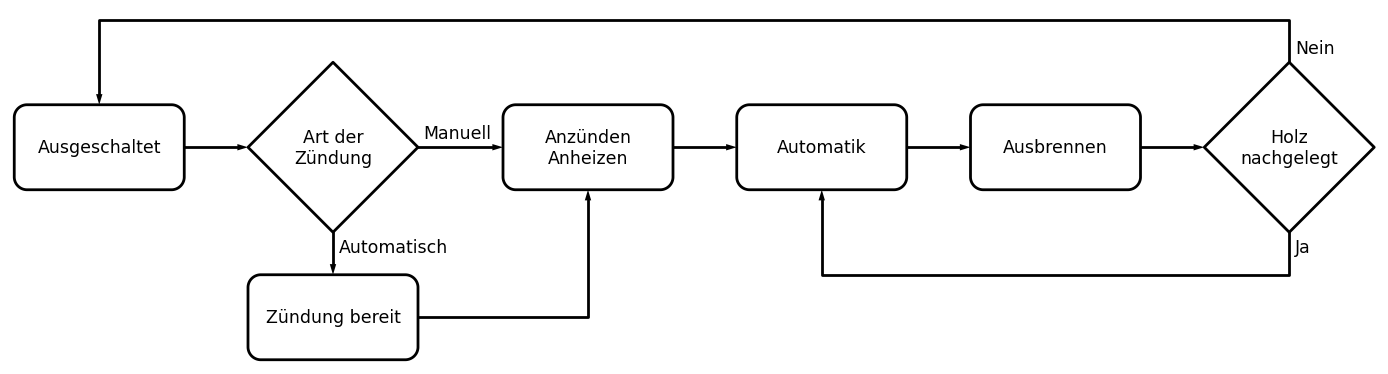

In [8]:
import schemdraw
from schemdraw.flow import *

with schemdraw.Drawing() as d:
    #Ausgeschaltet
    d+= (Ausgeschaltet := RoundBox(w = 4).label("Ausgeschaltet"))
    d+= Arrow().length(d.unit/2)
    
    #Manuelle oder automatische Zündung
    d+= (decision := Decision(w = 4, h= 4,
                       S = "Automatisch",
                        E = "Manuell").label("Art der\nZündung"))
    
    #Wenn manuell
    d+= Arrow().length(d.unit/1.5)
    d+= (Manuell := RoundBox(w = 4).label("Anzünden\nAnheizen"))
    d+= Arrow().length(d.unit/2)
    
    #Automatik 
    d+= (Automatik := RoundBox(w = 4).label("Automatik"))
    d+= Arrow().length(d.unit/2)
    
    #Ausbrennen 
    d+= (Ausbrennen := RoundBox(w = 4).label("Ausbrennen"))
    d+= Arrow().length(d.unit/2)
    
    #Holz nachgelegt
    d+= (decision2 := Decision(w = 4, h= 4,
                       N = "Nein",
                        S = "Ja").label("Holz\nnachgelegt"))
    
    #Wenn automatisch
    d+= Arrow().down(d.unit).at(decision.S).length(d.unit/3)
    d+= (Automatisch := RoundBox(w = 4).label("Zündung bereit"))
    d+= Wire('-|', arrow='->').at(Automatisch.E).to(Manuell.S)
    
    #Wenn Holz nachgelegt
    d+= Wire('n', k=-1, arrow='->').at(decision2.S).to(Automatik.S)
    
    #Wenn kein Holz nachgelegt
    d+= Wire('n', k=1, arrow='->').at(decision2.N).to(Ausgeschaltet.N)


# Datenverständnis

Die Arbeit baut im Wesentlichen auf zwei Datenquellen auf.
Der Holzofen zeichnet Daten auf und speichert diese auf einer SD-Karte. Alle 10 Sekunden werden insgesamt 62 Werte erfasst. Daten für den Holzofen, der hier betrachtet werden soll, liegen seit dem 12.11.2019 um 15:50 Uhr vor. Die letzten Daten wurden am 31.08.2023 um 11:49 Uhr abgerufen. Nachfüllintervalle variieren zwischen 2-3 mal täglich im Winter und mehrmals wöchentlich im Sommer. Damit ergeben sich bereits über 1.000 aufgezeichnete Nachfüllungen, aus denen das Modell gespeist werden kann.

Der Ofen liefert unter anderem:
* Temperaturdaten
    * Außentemperatur (über externen Sensor)
    * Kesseltemperatur
    * Brennraumtemperatur
    * Vorlauftemperatur
    * Puffertemperatur
* Daten zu Primär- und Sekundärluftzufuhr
* Pufferdaten
    * Ladegrade
    * Energie nutzbar/aufnehmbar
* Aktueller Betriebszustand
* Nachlegemenge und -Zeitpunkt
* Betriebsstunden

Als zweite Datenquelle werden externe Wetterdaten verwendet. In dieser Arbeit werden dazu die Wetterdaten von Meteostat über eine API abgerufen. Die Daten werden ursprünglich vom Deutschen Wetterdienst erhoben. Die API liefert stündliche Daten. Für das Modell werden die Daten in dem Zeitraum abgerufen, für den Ofendaten vorliegen. Die API liefert eine Vielzahl an Daten, für dieses Modell werden allerdings nur Außentemperatur, Windgeschwindigkeit und -richtung verwendet.

[Wetterrückblick und Klimadaten](https://meteostat.net/de/)